In [ ]:
!pip install torchmetrics
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 4.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 798 kB 4.6 MB/s 
     |████████████████████████████████| 87 kB 8.4 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115940 sha256=a2126e75041fcd7f6bdc9bdf32c4f353258fac4b2833f3d1a5d48da8aa377fb8
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pytorch_lightning as pl
import torchmetrics

import sys
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import os
import numpy as np
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class SegYDataset(Dataset):
    def __init__(self, length = 100, size = 64, percentage_density=10, density_value = None):
        self.fault_data = np.load('/content/drive/MyDrive/real_data/reduced_fault_data.npy')
        self.seis_data = np.load('/content/drive/MyDrive/real_data/reduced_seis_data.npy')
        self.length = length
        self.size = size
        self.percentage_density = percentage_density
        self.density_value = density_value if density_value is not None else ((size ** 3) * percentage_density) // 100
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        IL, XL, Z = self.seis_data.shape
        while True:
            iline = random.randint(0, IL - self.size)
            xline = random.randint(0, XL - self.size)
            zline = random.randint(0, Z - self.size)
            fault_slice = self.fault_data[iline: iline+self.size,
                                          xline: xline+self.size,
                                          zline: zline+self.size]
            if fault_slice.sum() > self.density_value:
                seis_slice = self.seis_data[iline: iline+self.size,
                                            xline: xline+self.size,
                                            zline: zline+self.size]
                X = torch.Tensor(seis_slice)
                Y = torch.Tensor(fault_slice)
                return (X[None,:], Y[None, :])
                

In [ ]:
train_dataset = SegYDataset(100, 64, 10)
trainloader = DataLoader(train_dataset, batch_size=1)

In [ ]:
class UNet3D_512(nn.Module):
    def __init__(self):
        super(UNet3D_512, self).__init__()
        
        self.layer_encoder_1 = self.__get_encoder_layer(1, 32, kernel_size=3, stride=1, padding=1)
        self.layer_encoder_2 = self.__get_encoder_layer(32, 64, kernel_size=3, stride=1, padding=1)

        self.layer_encoder_3 = self.__get_encoder_layer(64, 64, kernel_size=3, stride=1, padding=1)
        self.layer_encoder_4 = self.__get_encoder_layer(64, 128, kernel_size=3, stride=1, padding=1)
        
        self.layer_encoder_5 = self.__get_encoder_layer(128, 128, kernel_size=3, stride=1, padding=1)
        self.layer_encoder_6 = self.__get_encoder_layer(128, 256, kernel_size=3, stride=1, padding=1)
        
        self.layer_encoder_7 = self.__get_encoder_layer(256, 256, kernel_size=3, stride=1, padding=1)
        self.layer_encoder_8 = self.__get_encoder_layer(256, 512, kernel_size=3, stride=1, padding=1)
        
        self.max_pool_1 = nn.MaxPool3d(2)
        self.max_pool_2 = nn.MaxPool3d(2)
        self.max_pool_3 = nn.MaxPool3d(2)
        
        self.layer_decoder_1 = self.__get_decoder_layer(512, 512, kernel_size=2, stride=2)
        self.layer_decoder_2 = self.__get_encoder_layer(256 + 512, 256, kernel_size=3, stride=1, padding=1)
        self.layer_decoder_3 = self.__get_encoder_layer(256, 256, kernel_size=3, stride=1, padding=1)
        
        self.layer_decoder_4 = self.__get_decoder_layer(256, 256, kernel_size=2, stride=2)
        self.layer_decoder_5 = self.__get_encoder_layer(128 + 256, 128, kernel_size=3, stride=1, padding=1)
        self.layer_decoder_6 = self.__get_encoder_layer(128, 128, kernel_size=3, stride=1, padding=1)
        
        self.layer_decoder_7 = self.__get_decoder_layer(128, 128, kernel_size=2, stride=2)
        self.layer_decoder_8 = self.__get_encoder_layer(64 + 128, 64, kernel_size=3, stride=1, padding=1)
        self.layer_decoder_9 = self.__get_encoder_layer(64, 1, kernel_size=3, stride=1, padding=1)
        self.layer_10 = nn.Sequential(nn.Conv3d(1, 1,kernel_size=1, stride=1))
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):

        
        # ----------encoder start----------

        first_layer_encoder = self.layer_encoder_2(self.layer_encoder_1(x))
        x = self.max_pool_1(first_layer_encoder)
        
        second_layer_encoder = self.layer_encoder_4(self.layer_encoder_3(x))
        x = self.max_pool_2(second_layer_encoder)
        third_layer_encoder = self.layer_encoder_6(self.layer_encoder_5(x))
        
        x = self.max_pool_3(third_layer_encoder)
        x = self.layer_encoder_8(self.layer_encoder_7(x))
        # ----------encoder end----------
        
        # ----------decoder start----------
        x = self.layer_decoder_1(x)
        third_layer_decoder = torch.cat((x, third_layer_encoder),1)
        del third_layer_encoder
        x = self.layer_decoder_3(self.layer_decoder_2(third_layer_decoder))
        del third_layer_decoder

        x = self.layer_decoder_4(x)
        second_layer_decoder = torch.cat((x, second_layer_encoder),1)
        del second_layer_encoder
        x = self.layer_decoder_6(self.layer_decoder_5(second_layer_decoder))
        del second_layer_decoder
        
        x = self.layer_decoder_7(x)
        first_layer_decoder = torch.cat((x, first_layer_encoder),1)
        del first_layer_encoder
        x = self.layer_decoder_9(self.layer_decoder_8(first_layer_decoder))
        del first_layer_decoder
        # ----------edcoder end----------
        x = self.layer_10(x)
        # x = self.sigmoid(x)
        return x
    
    def __get_encoder_layer(self, input_channel=1, output_channel=64, kernel_size=3, stride=1, padding=0, batch_norm=True, padding_mode='replicate'):
        if batch_norm:
            return nn.Sequential(nn.Conv3d(input_channel, output_channel,
                                           kernel_size=kernel_size, stride=stride, padding=padding, padding_mode=padding_mode),
                             nn.BatchNorm3d(output_channel),
                             nn.ReLU())
        return nn.Sequential(nn.Conv3d(input_channel, output_channel, kernel_size=kernel_size, stride=stride, padding=padding),
                 nn.ReLU())
    
    def __get_decoder_layer(self, input_channel=1, output_channel=64, kernel_size=3, stride=1, padding=0):
        return nn.Sequential(nn.ConvTranspose3d(input_channel, output_channel, kernel_size=kernel_size,
                                                stride=stride, padding=padding),
                             nn.ReLU())

In [ ]:
class UNet3D_256(nn.Module):
    def __init__(self):
        super(UNet3D_256, self).__init__()
        
        self.layer_encoder_1 = self.__get_encoder_layer(1, 16, kernel_size=3, stride=1, padding=1)
        self.layer_encoder_2 = self.__get_encoder_layer(16, 32, kernel_size=3, stride=1, padding=1)

        self.layer_encoder_3 = self.__get_encoder_layer(32, 32, kernel_size=3, stride=1, padding=1)
        self.layer_encoder_4 = self.__get_encoder_layer(32, 64, kernel_size=3, stride=1, padding=1)
        
        self.layer_encoder_5 = self.__get_encoder_layer(64, 64, kernel_size=3, stride=1, padding=1)
        self.layer_encoder_6 = self.__get_encoder_layer(64, 128, kernel_size=3, stride=1, padding=1)
        
        self.layer_encoder_7 = self.__get_encoder_layer(128, 128, kernel_size=3, stride=1, padding=1)
        self.layer_encoder_8 = self.__get_encoder_layer(128, 256, kernel_size=3, stride=1, padding=1)
        
        self.max_pool_1 = nn.MaxPool3d(2)
        self.max_pool_2 = nn.MaxPool3d(2)
        self.max_pool_3 = nn.MaxPool3d(2)
        
        self.layer_decoder_1 = self.__get_decoder_layer(256, 256, kernel_size=2, stride=2)
        self.layer_decoder_2 = self.__get_encoder_layer(128 + 256, 128, kernel_size=3, stride=1, padding=1)
        self.layer_decoder_3 = self.__get_encoder_layer(128, 128, kernel_size=3, stride=1, padding=1)
        
        self.layer_decoder_4 = self.__get_decoder_layer(128, 128, kernel_size=2, stride=2)
        self.layer_decoder_5 = self.__get_encoder_layer(64 + 128, 64, kernel_size=3, stride=1, padding=1)
        self.layer_decoder_6 = self.__get_encoder_layer(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.layer_decoder_7 = self.__get_decoder_layer(64, 64, kernel_size=2, stride=2)
        self.layer_decoder_8 = self.__get_encoder_layer(32 + 64, 32, kernel_size=3, stride=1, padding=1)
        self.layer_decoder_9 = self.__get_encoder_layer(32, 1, kernel_size=3, stride=1, padding=1)
        self.layer_10 = nn.Sequential(nn.Conv3d(1, 1,kernel_size=1, stride=1))
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        # ----------encoder start----------

        first_layer_encoder = self.layer_encoder_2(self.layer_encoder_1(x))
        x = self.max_pool_1(first_layer_encoder)
        
        second_layer_encoder = self.layer_encoder_4(self.layer_encoder_3(x))
        x = self.max_pool_2(second_layer_encoder)
        third_layer_encoder = self.layer_encoder_6(self.layer_encoder_5(x))
        
        x = self.max_pool_3(third_layer_encoder)
        x = self.layer_encoder_8(self.layer_encoder_7(x))
        # ----------encoder end----------
        
        # ----------decoder start----------
        x = self.layer_decoder_1(x)
        third_layer_decoder = torch.cat((x, third_layer_encoder),1)
        del third_layer_encoder
        x = self.layer_decoder_3(self.layer_decoder_2(third_layer_decoder))
        del third_layer_decoder

        x = self.layer_decoder_4(x)
        second_layer_decoder = torch.cat((x, second_layer_encoder),1)
        del second_layer_encoder
        x = self.layer_decoder_6(self.layer_decoder_5(second_layer_decoder))
        del second_layer_decoder
        
        x = self.layer_decoder_7(x)
        first_layer_decoder = torch.cat((x, first_layer_encoder),1)
        del first_layer_encoder
        x = self.layer_decoder_9(self.layer_decoder_8(first_layer_decoder))
        del first_layer_decoder
        # ----------edcoder end----------
        x = self.layer_10(x)
        # x = self.sigmoid(x)
        return x
    
    def __get_encoder_layer(self, input_channel=1, output_channel=64, kernel_size=3, stride=1, padding=0, batch_norm=True, padding_mode='replicate'):
        if batch_norm:
            return nn.Sequential(nn.Conv3d(input_channel, output_channel,
                                           kernel_size=kernel_size, stride=stride, padding=padding, padding_mode=padding_mode),
                             nn.BatchNorm3d(output_channel),
                             nn.ReLU())
        return nn.Sequential(nn.Conv3d(input_channel, output_channel, kernel_size=kernel_size, stride=stride, padding=padding),
                 nn.ReLU())
    
    def __get_decoder_layer(self, input_channel=1, output_channel=64, kernel_size=3, stride=1, padding=0):
        return nn.Sequential(nn.ConvTranspose3d(input_channel, output_channel, kernel_size=kernel_size,
                                                stride=stride, padding=padding))

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy(inputs,  targets.float())
        # loss = torch.pow(torch.sub(1, torch.exp(-bce_loss)), self.gamma)
        # loss = torch.mul(loss, bce_loss)
        # loss = torch.mul(loss, self.alpha)
        loss = self.alpha * (1 - torch.exp(-bce_loss)) ** self.gamma * bce_loss
        return loss

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets)
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [ ]:
def my_dice_score(y_pred, y, smooth=1):
    intersection = (y_pred * y).sum() 
    score = 1 - (2.*intersection + smooth)/(y_pred.sum() + y.sum() + smooth)
    return score

In [ ]:
class LitModel(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss = DiceBCELoss()
        self.dice = my_dice_score

    def forward(self, x):
        y_pred = self.model(x)
        return y_pred
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters())
        return optimizer
    
    def get_metrics(self, y_pred, y, metrics_type="train"):
        y = y.type(torch.IntTensor)
        y = y.view(-1).to('cuda')
        y_pred = y_pred.view(-1).to('cuda')
        
        # acc = self.iou(y_pred, y)
        dice = self.dice(y_pred, y)

        # self.log(f'acc/{metrics_type}', acc)
        self.log(f'dice/ {metrics_type}', dice)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        
        y_pred = self.forward(x)
        loss = self.loss(y_pred, y)
        # self.get_metrics(y_pred, y, "train")
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch

        y_pred = self.forward(x)
        loss = self.loss(y_pred, y)
        # self.get_metrics(y_pred, y, "val")
        return loss

In [ ]:
model = UNet3D_256()

unet_model = LitModel(model)
trainer_unet_model = pl.Trainer(max_epochs=10, accelerator='gpu')
trainer_unet_model.fit(unet_model, trainloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type        | Params
--------------------------------------
0 | model | UNet3D_256  | 4.7 M 
1 | loss  | DiceBCELoss | 0     
--------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.975    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
X,Y = next(iter(trainloader))

In [ ]:
res = unet_model.model(X)

In [ ]:
res

tensor([[[[[-2.8689, -2.8866, -2.9428,  ..., -3.2239, -3.1898, -3.1714],
           [-2.8867, -2.9044, -2.9586,  ..., -3.2414, -3.2080, -3.1899],
           [-2.8178, -2.8351, -2.8871,  ..., -3.2001, -3.1678, -3.1504],
           ...,
           [-3.1868, -3.2015, -3.2609,  ..., -3.1101, -3.0634, -3.0446],
           [-3.0830, -3.1029, -3.1640,  ..., -3.0183, -2.9706, -2.9516],
           [-3.0295, -3.0518, -3.1122,  ..., -2.9710, -2.9227, -2.9035]],

          [[-2.8882, -2.9052, -2.9615,  ..., -3.2503, -3.2153, -3.1955],
           [-2.9027, -2.9202, -2.9747,  ..., -3.2648, -3.2304, -3.2105],
           [-2.8312, -2.8490, -2.9024,  ..., -3.2227, -3.1908, -3.1712],
           ...,
           [-3.1941, -3.2075, -3.2706,  ..., -3.1256, -3.0773, -3.0562],
           [-3.0874, -3.1067, -3.1725,  ..., -3.0306, -2.9814, -2.9598],
           [-3.0320, -3.0536, -3.1187,  ..., -2.9810, -2.9304, -2.9093]],

          [[-2.8984, -2.9168, -2.9737,  ..., -3.2766, -3.2420, -3.2190],
           [-2.

In [ ]:
torch.sigmoid(res).detach().numpy()[0][0][id, :, :]

array([[0.06063475, 0.05882921, 0.05491796, ..., 0.03280749, 0.03314257,
        0.03349965],
       [0.06065649, 0.05903982, 0.05534594, ..., 0.03270706, 0.03319123,
        0.03357303],
       [0.06967035, 0.06826659, 0.06435896, ..., 0.0345798 , 0.03514921,
        0.03562225],
       ...,
       [0.0376101 , 0.03725675, 0.03684727, ..., 0.03718204, 0.0375938 ,
        0.03809598],
       [0.04109332, 0.04066078, 0.04025769, ..., 0.04092924, 0.04158649,
        0.04226479],
       [0.04318981, 0.0427081 , 0.04231519, ..., 0.04310718, 0.04397572,
        0.04484093]], dtype=float32)

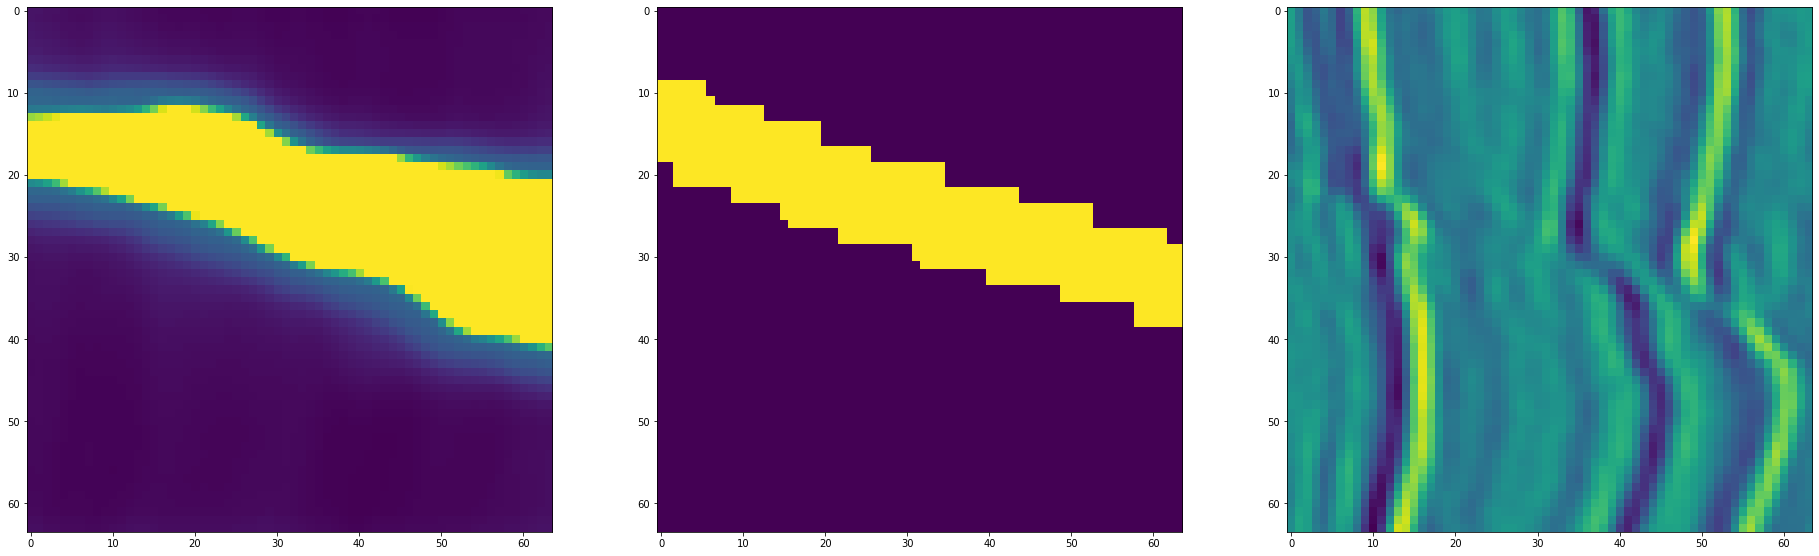

In [ ]:
id = 0
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(32, 18))
ax1.imshow((torch.sigmoid(res)).detach().numpy()[0][0][id, :, :])
ax2.imshow(Y[0][0][id, :, :])
ax3.imshow(X[0][0][id, :, :])

In [ ]:
# (res == 0.5).sum()

In [ ]:
# (res != 0.5).sum()

In [ ]:
# next(iter(trainloader))[1].sum()